# Detecção de outliers
Pode ser interessante detectar outliers entre os clientes da feira para descobrir possíveis compradores que sejam pessoas jurídicas que realizam compras com o intuito de revenda. Caso encontrados, algum tipo de convênio poderia ser firmado com tais clientes.<p>
Faremos esta análise utilizando DBSCAN para agrupar clientes por meio do valor total gasto e da quantidade total de produtos adquiridos.
<P><FONT COLOR='RED'><B>ATENÇÃO: BOTAR QUANTIDADE DE PEDIDOS NO X</B></FONT>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [2]:
df = pd.read_csv('arquivos/clientes_final.csv')
df = df.filter(['id_cliente','vl_total_compras','qt_total_itens'])
df.head()

,id_cliente,vl_total_compras,qt_total_itens
0,31,2109.05,214
1,33,290.80,34
2,34,9108.60,882
3,35,774.05,69
4,36,190.80,32


Vamos determinar nosso X e normalizar seus dados, já que tratar-se-á de duas colunas que utilizam unidades diferentes. A coluna de identificação do cliente será reutilizada posteriormente.

In [3]:
X = df[['vl_total_compras','qt_total_itens']]

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

O DBSCAN se utiliza do conceito de densidade dos pontos para separá-los em agrupamentos. Para calcular esta densidade, existem dois hiper parâmetros:
- epsilon (eps), que determina a distância estendida de um ponto;
- número mínimo de pontos (ms) que devem estar dentro do raio determinado por epsilon para que um ponto seja considerado um ponto *core*. Pontos *core* fazem parte de um cluster. Pontos que não estiverem ao alcance de nenhum ponto são considerados outliers. Caso um ponto tenha ao menos um ponto dentro de seu raio, porém não atinja o número mínimo, será um ponto *border*, e também não será considerado um outlier.<p>

Posto isto, iremos determinar que o número mínimo de pontos será 4 (o dobro da quantidade de parâmetros) e tentaremos descobrir o melhor valor para epsilon, que reduza a quantidade de outliers para um percentual analisável.

In [4]:
percent_outliers = list()
ms = scaled_X.shape[1] * 2

lista_eps = np.linspace(0.001,3,50) # 50 valores que testaremos para eps

for eps in lista_eps:
    modelo = DBSCAN(min_samples=ms,eps=eps)
    modelo.fit(scaled_X)
    
    nr_outliers = np.sum(modelo.labels_ == -1) # DBSCAN atribui label -1 aos outliers
    perc_outliers = 100 * nr_outliers / len(modelo.labels_)
    percent_outliers.append(perc_outliers)

Agora vamos visualizar o percentual de outliers para cada valor testado para epsilon, o que nos ajudará a escolher o seu valor final.

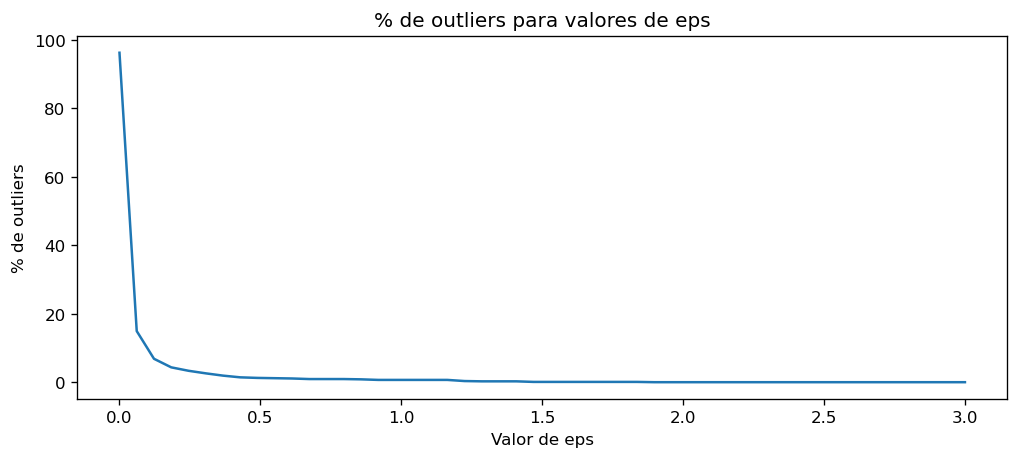

In [5]:
plt.figure(dpi=120,figsize=(10,4))
ax = sns.lineplot(x=lista_eps,y=percent_outliers)
ax.set(xlabel='Valor de eps',ylabel='% de outliers',title='% de outliers para valores de eps');

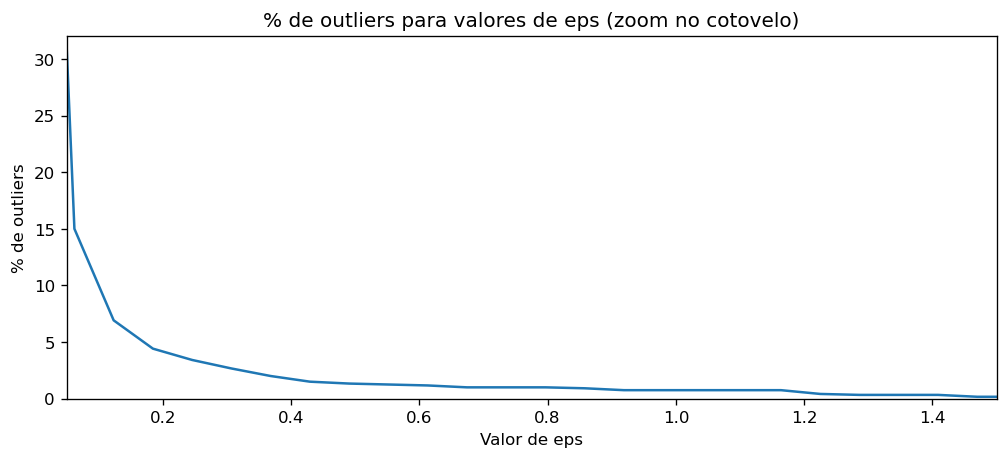

In [6]:
plt.figure(dpi=120,figsize=(10,4))
ax = sns.lineplot(x=lista_eps,y=percent_outliers)
ax.set(xlabel='Valor de eps',ylabel='% de outliers',title='% de outliers para valores de eps (zoom no cotovelo)')
plt.xlim(0.05,1.5)
plt.ylim(0,32);

Como temos 1.200 clientes, selecionaremos 0.7 para epsilon, caso contrário teremos uma lista muito grande de outliers, o que pode acabar se tornando difícil de analisar. Vamos treinar nosso modelo.

In [7]:
modelo = DBSCAN(min_samples=ms,eps=0.7)
labels = modelo.fit_predict(scaled_X)
df['label'] = labels
df['label'].value_counts()

 0    1188
-1      12
Name: label, dtype: int64

Podemos verificar que foi criado somente um cluster com 1.188 clientes, restando 12 como ouliers. Vale salientar que, dependo dos hiperparâmetros que utilizássemos, poderiam ter sido criados mais clusteres.<p>
Como nosso X é bi-dimensional, podemos plotar os dados em um scatter plot e verificar como foram agrupados os clientes.

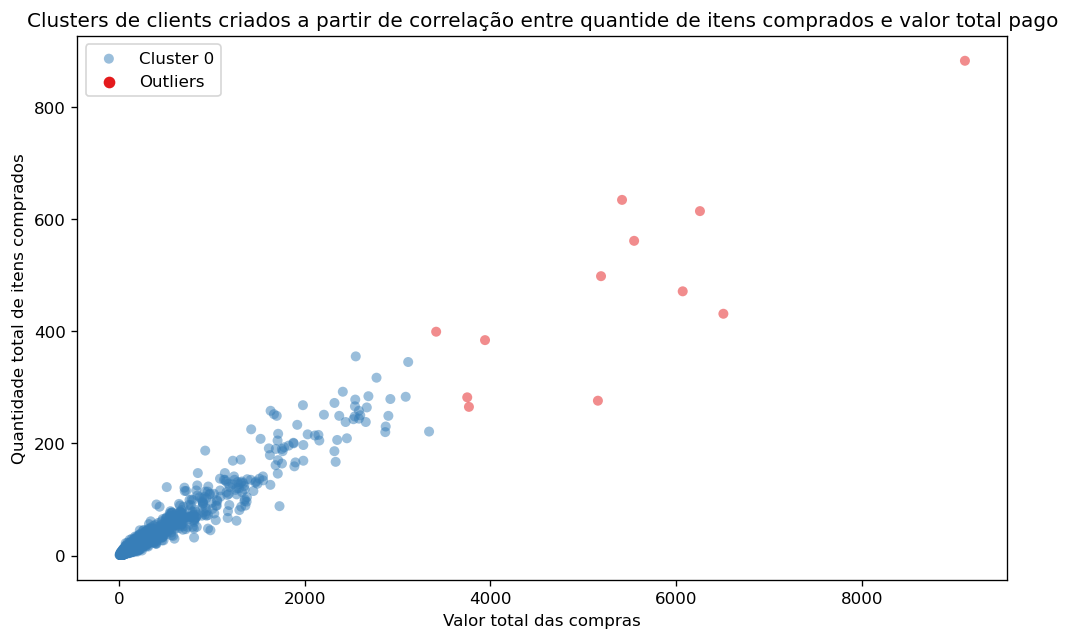

In [8]:
plt.figure(dpi=120,figsize=(10,6))
ax = sns.scatterplot(data=df,x='vl_total_compras',y='qt_total_itens',hue='label',palette='Set1',alpha=0.5,
                     linewidth=0)
ax.set(
    title='Clusters de clients criados a partir de correlação entre quantide de itens comprados e valor total pago',
    xlabel='Valor total das compras',ylabel='Quantidade total de itens comprados')
plt.legend(labels=['Cluster 0','Outliers']);

A princípio é possível imaginar que tal análise poderia ter sido feita simplesmente com a plotagem dos dados num gráfico, mas a utilização de DBSCAN, que acrescentou um label a cada cliente, facilita a visualização dos clientes no DataFrame, como podemos ver a seguir.

In [9]:
df[df['label'] == -1]

,id_cliente,vl_total_compras,qt_total_itens,label
2,34,9108.60,882,-1
15,47,6507.90,431,-1
39,72,6070.00,471,-1
164,217,5547.00,561,-1
166,220,3768.40,265,-1
190,246,3750.10,282,-1
242,301,5157.00,276,-1
270,333,5190.60,498,-1
320,390,3415.55,399,-1
343,418,6255.60,614,-1
